In [12]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Trends

In [13]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", (1940, 2022), None, -80, 30, 20, 80, [200, 250, 300])
all_jets, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)
props_as_ds["nao"] = get_nao(props_as_ds)

# DST

In [3]:
from CDSK import dynamical_local_indexes

In [4]:
subset = ['Lat', 'Lon', 'Spe', "mean_lev", 'lon_ext', 'width', 'tilt', 'sinuosity', 'int', 'persistence']
jets = props_as_ds.jet.values

In [5]:
X = []
full_varname = []
time_mask1 = props_as_ds.time.dt.year >= 1979
time_mask2 = props_as_ds.time.dt.season == "JJA"
time_mask = time_mask1 & time_mask2
for varname, jet in product(subset, jets):
    if varname == "Lat":
        default_value = 50 if jet == "polar" else 30
    else:
        default_value = 1
    X.append(np.nan_to_num(props_as_ds[varname].sel(jet=jet, time=time_mask).values, nan=default_value))
    full_varname.append(f"{varname}_{jet}")
X = np.vstack(X).T[:, None, :].copy()

In [ ]:
lds = np.zeros(X.squeeze().shape)
thetas = np.zeros_like(lds)
for i in trange(X.shape[-1]):
    ld, theta, _ = dynamical_local_indexes(X[:, :, i], ql=0.98, ld_fit="SDFC", n_jobs=10)
    lds[:, i], thetas[:, i] = ld.squeeze(), theta.squeeze()

In [12]:
np.save("results/tmp/lds.npy", lds)
np.save("results/tmp/thetas.npy", thetas)

In [15]:
thetas.shape

(16192, 20)

In [8]:
ld, theta, _ = dynamical_local_indexes(X[:199, :, 0], ql=0.98, ld_fit="SDFC", n_jobs=5)

/storage/homefs/hb22g102/CDSK-python/CDSK/__dynamical_local_indexes.py:45: RuntimeWarning: invalid value encountered in scalar divide
  return (K + N + Nc - np.sqrt((K + N + Nc) ** 2 - 8 * Nc * K)) / (2 * K)
/storage/homefs/hb22g102/CDSK-python/CDSK/__dynamical_local_indexes.py:318: RuntimeWarning: invalid value encountered in divide
  alpha[:, i, j] = np.sum(where[:, :, i, i] & where[:, :, j, j], 1) / np.sum(where[:, :, i, i], 1)


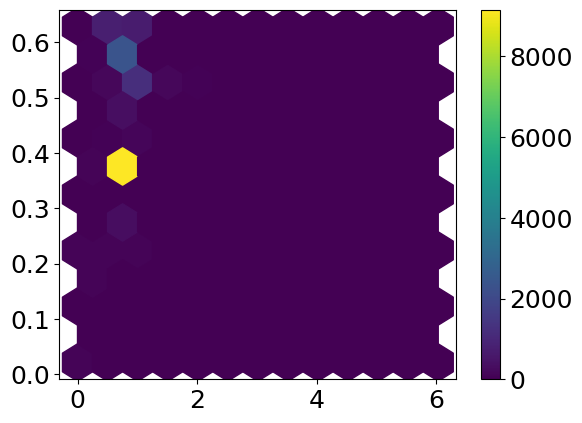

In [25]:
ld_ = ld[:, 0, 0]
ld_[ld_ > 1e7] = 0
im = plt.hexbin(ld_, theta.ravel(), gridsize=12)
plt.colorbar(im)
# plt.plot(ld_, theta.ravel(), "wx")

# Trends

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


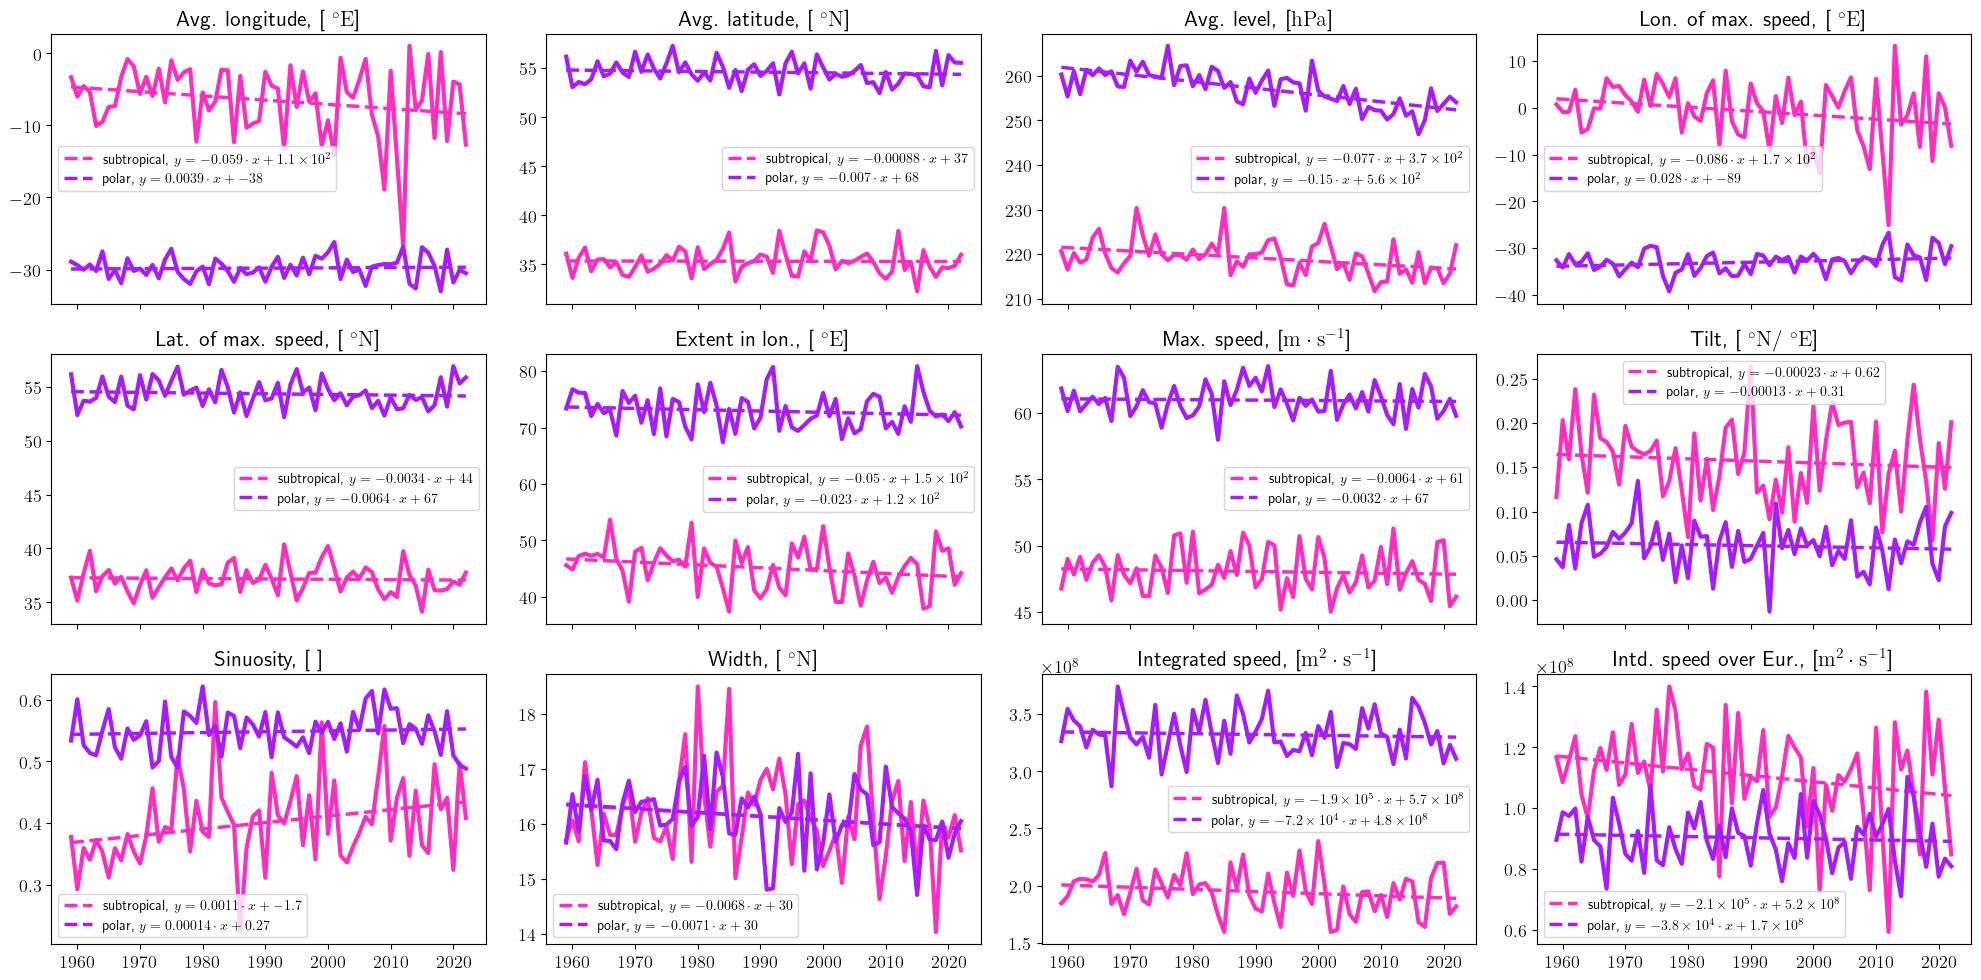

In [3]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [6, 7, 8])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").mean()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "Spe", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS[2 - j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_summer.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


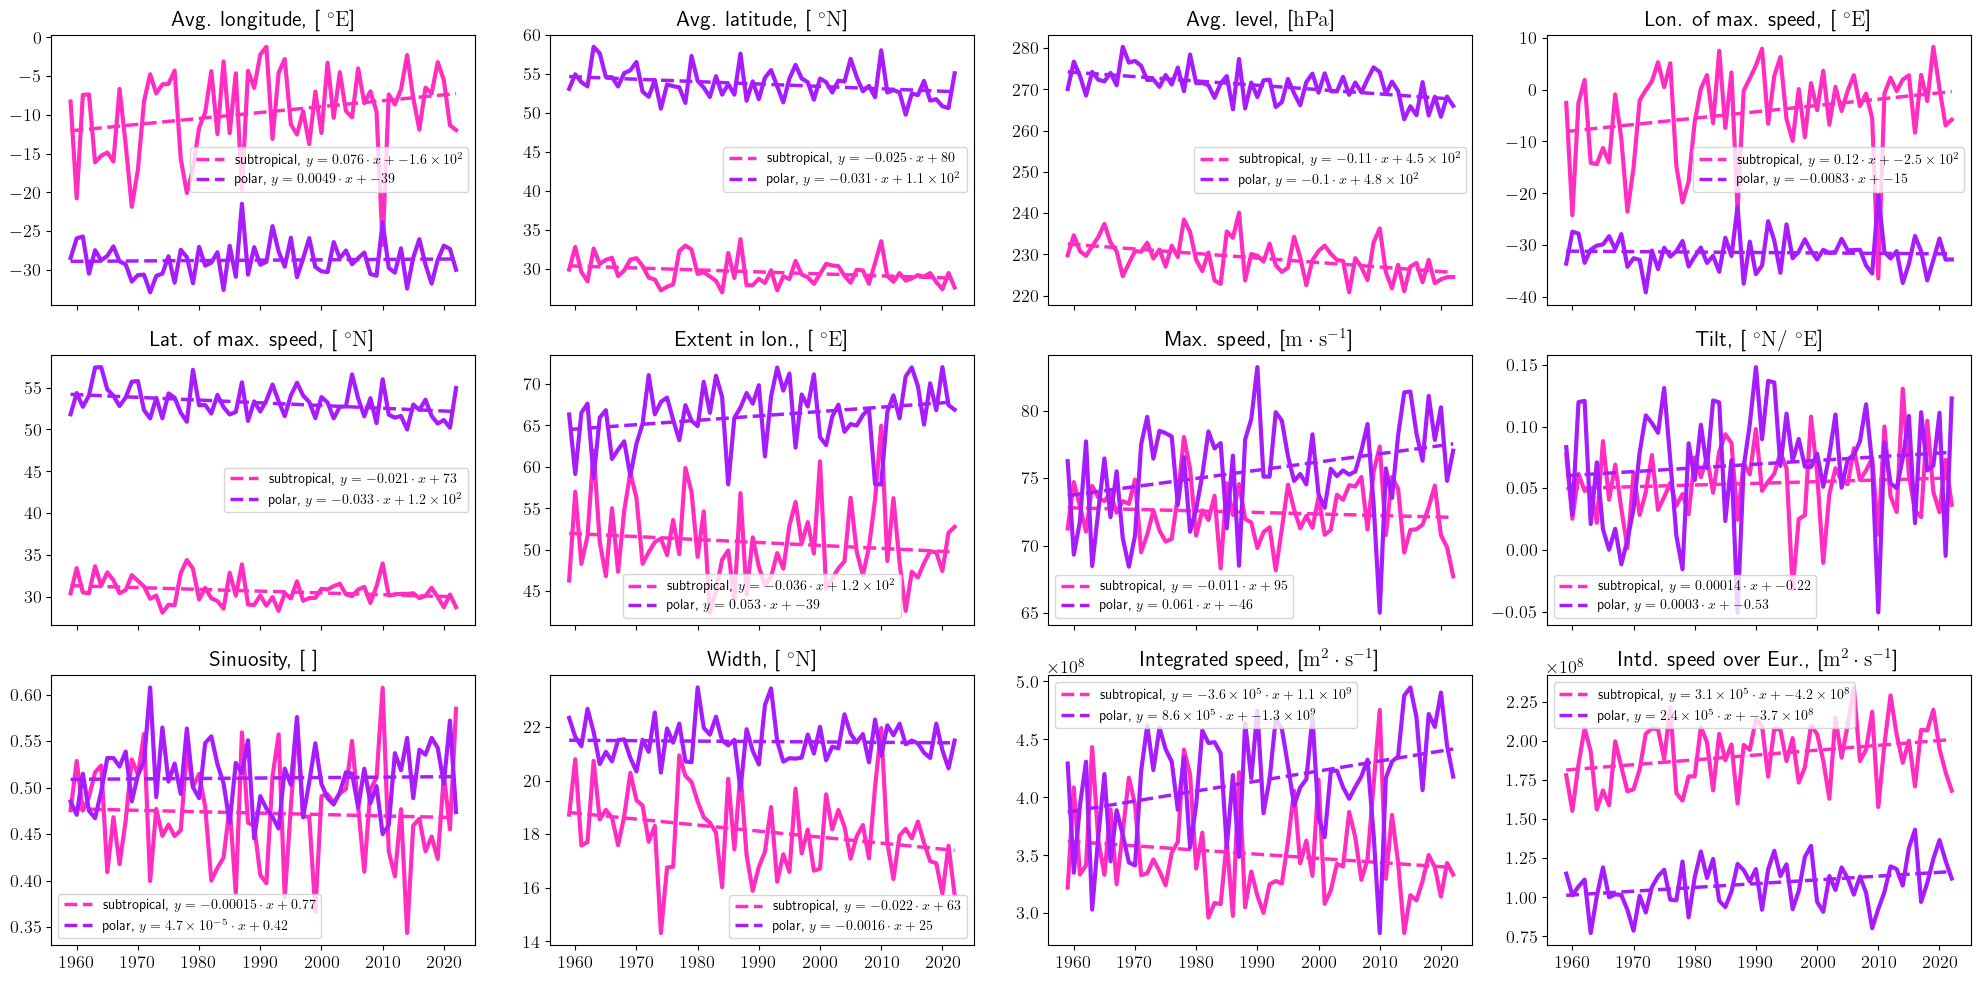

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [12, 1, 2])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").mean()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "Spe", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS[2 - j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_winter.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


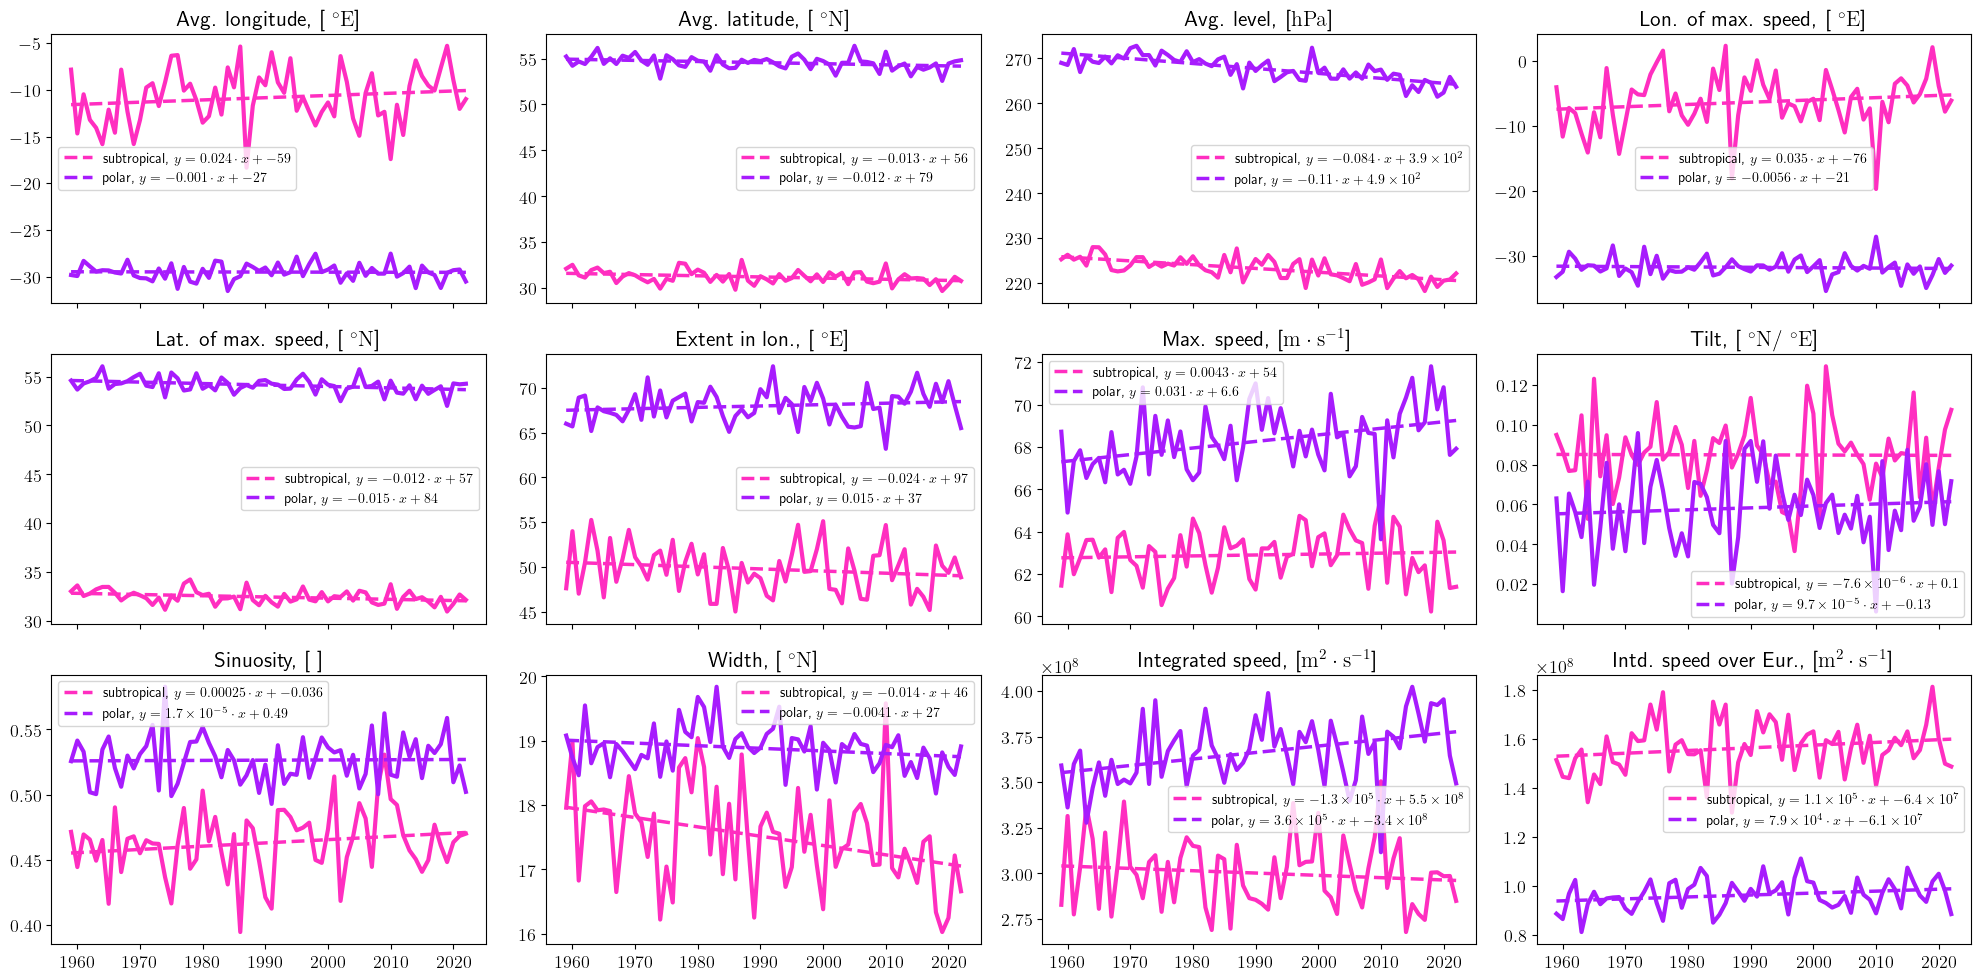

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
props_as_ds_yearly_hs = props_as_ds.resample(time="1Y").mean()
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "Spe", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS[2 - j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_allyear.png")

# Variability

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


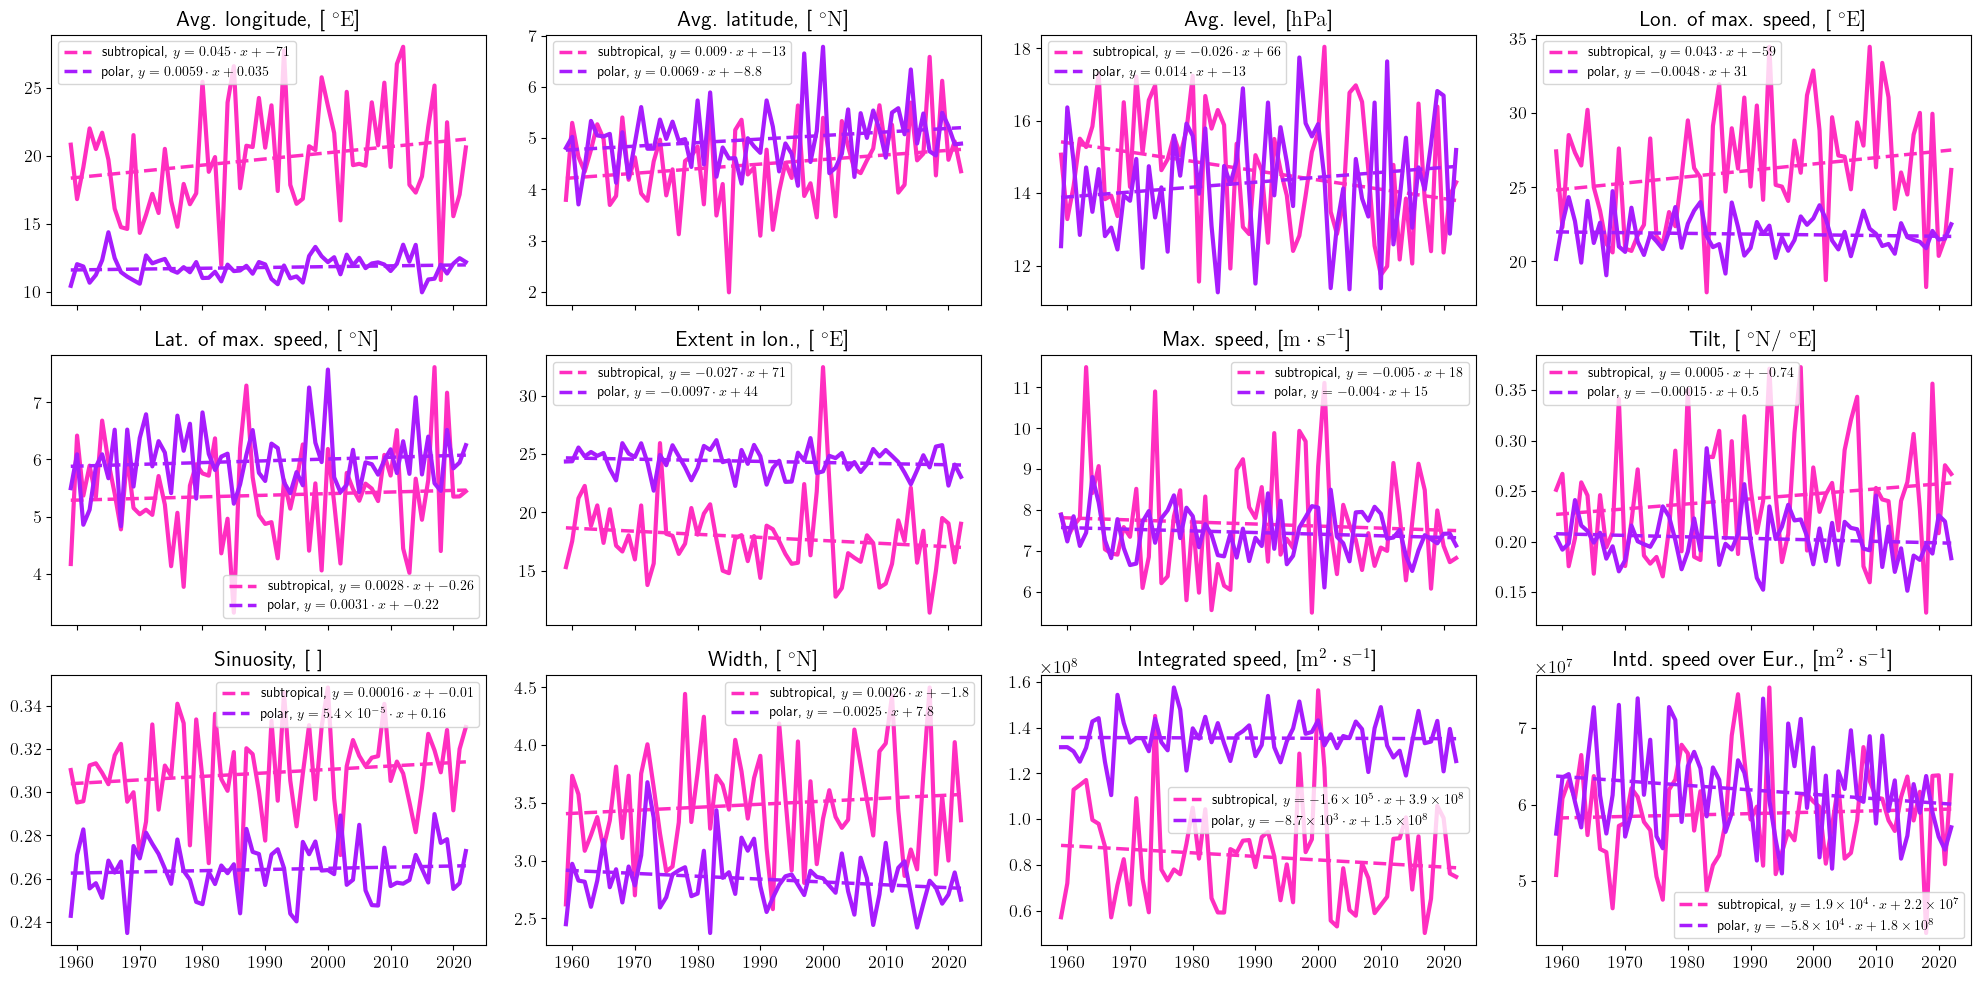

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [6, 7, 8])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").std()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "Spe", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS[2 - j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_std_post_1959_summer.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


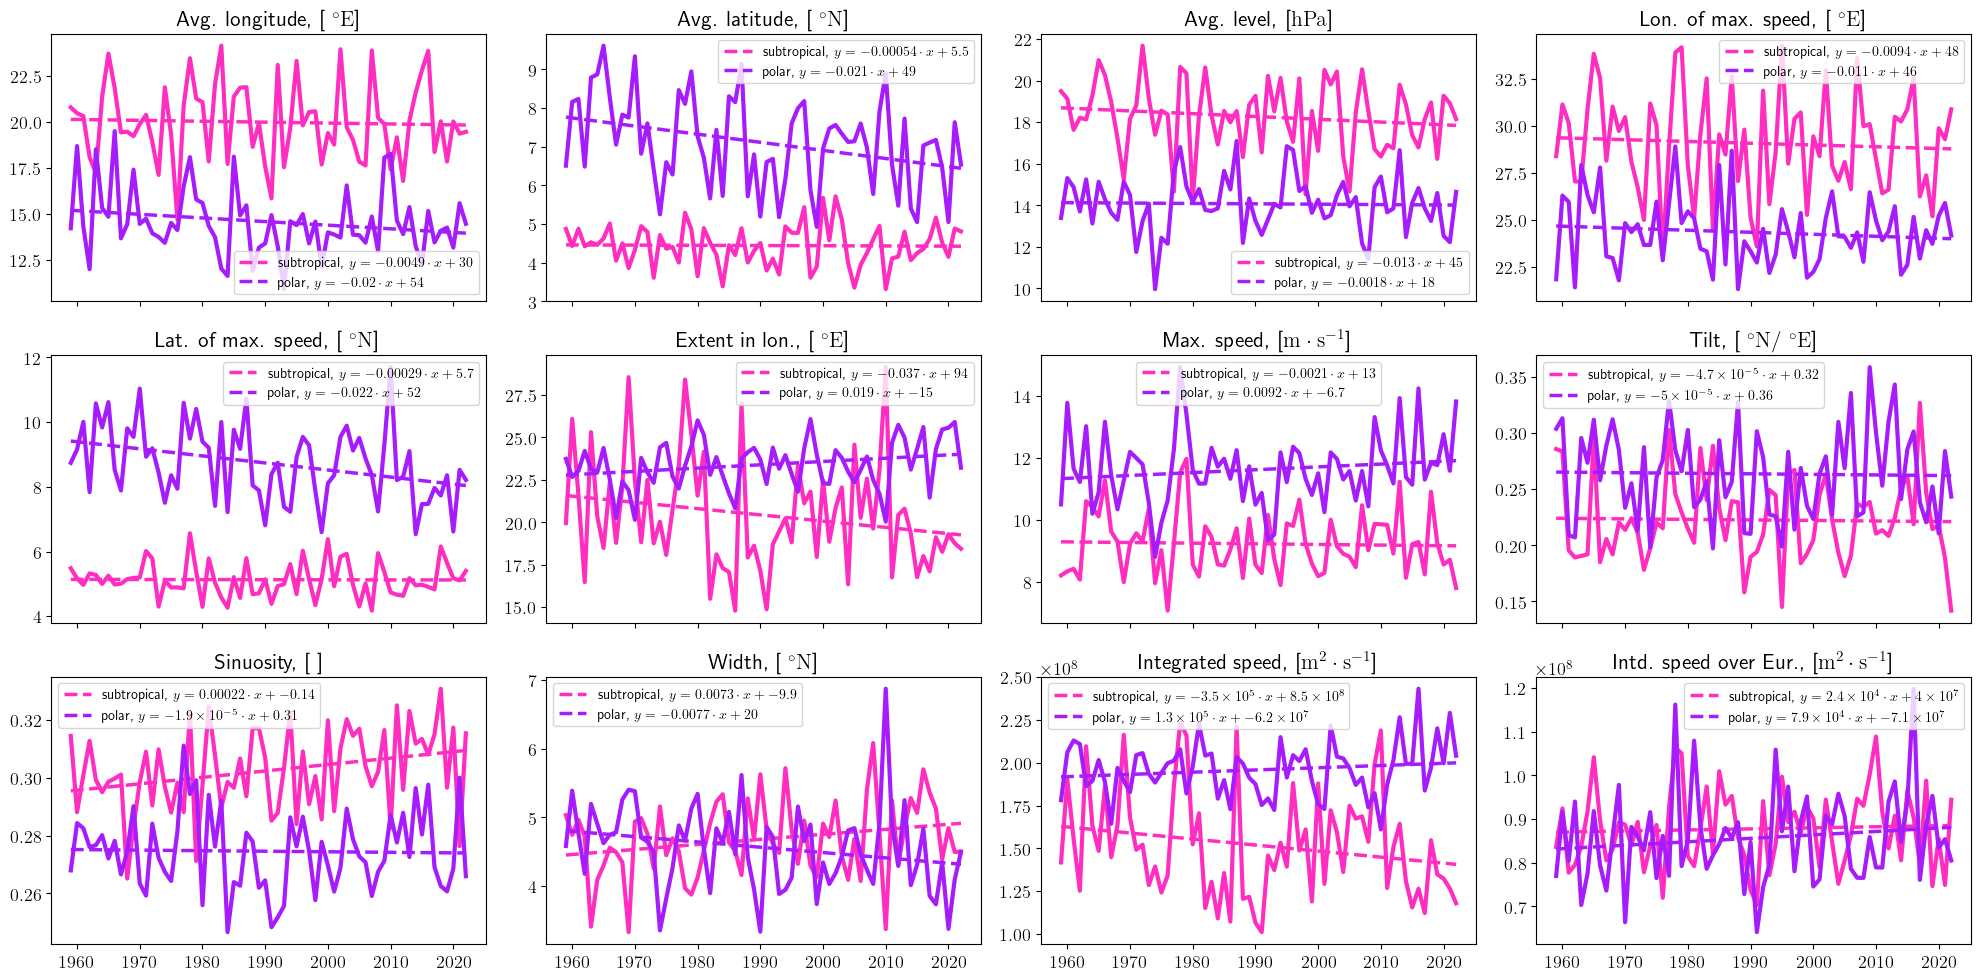

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [12, 1, 2])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").std()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "Spe", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS[2 - j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_std_post_1959_winter.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


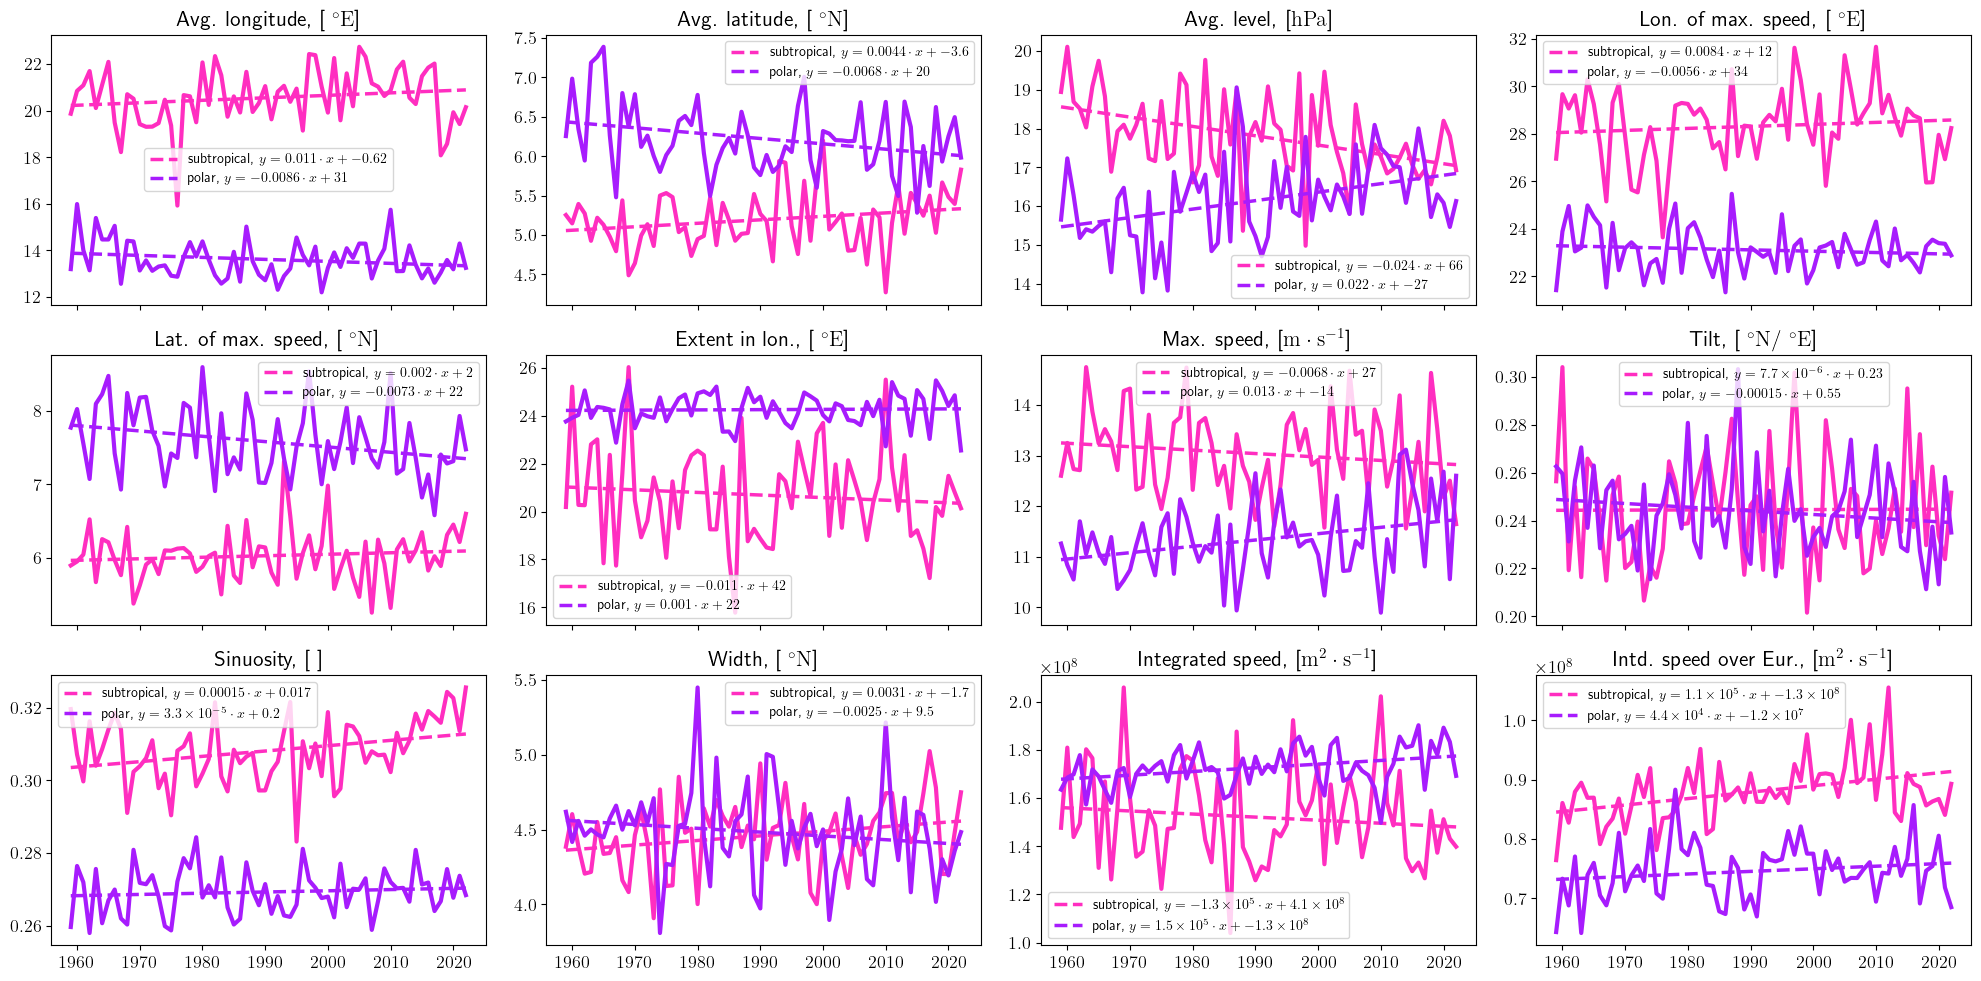

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
props_as_ds_yearly_hs = props_as_ds.resample(time="1Y").std()
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "Spe", "tilt", "sinuosity", "width", "int", "int_over_europe"]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS[2 - j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_std_post_1959_allyear.png")

# Correlations

In [19]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", (1959, 2022), "JJA", *exp.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da.reset_coords("lev", drop=True)

In [22]:
time_mask = (props_as_ds.time.dt.year >= 1959) & (props_as_ds.time.dt.season == "JJA")
props_as_ds_late = props_as_ds.sel(time=time_mask)
props_as_ds_late["anti_pv_activity"] = da_pvs.sel(type="anti").sum(dim=["lon", "lat"])
props_as_ds_late["cycl_pv_activity"] = da_pvs.sel(type="cycl").sum(dim=["lon", "lat"])
props_as_ds_late["n_jets"] = (~props_as_ds_uncat["mean_lat"].isnull()).sum(dim="jet")
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)

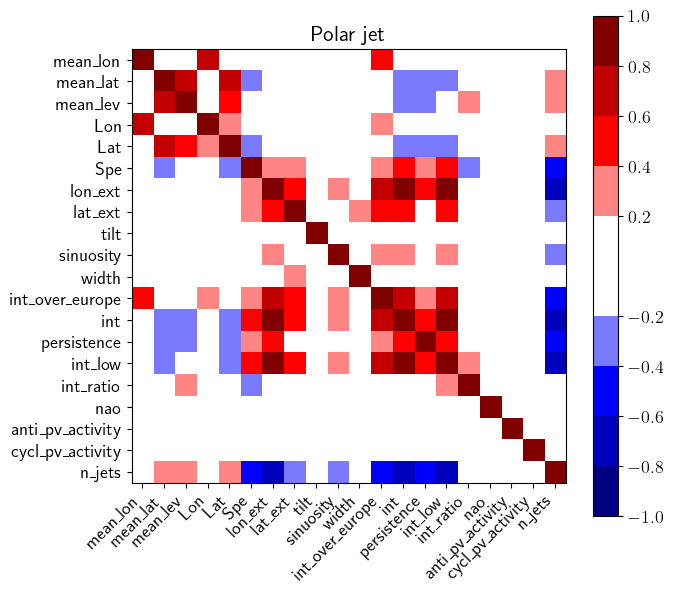

In [24]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="polar").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
    ]:
        to_concat.append(da.sel(jet="polar").values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_polar.png")

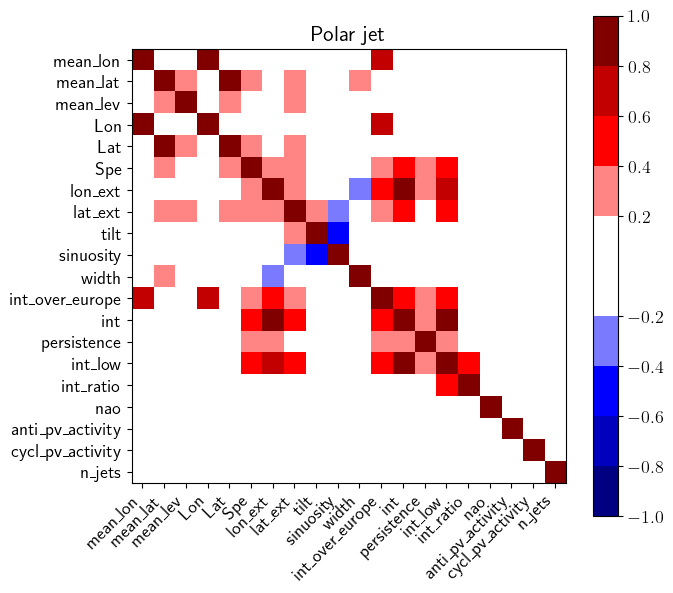

In [25]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="subtropical").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
    ]:
        to_concat.append(da.sel(jet="subtropical").values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_subtropical.png")

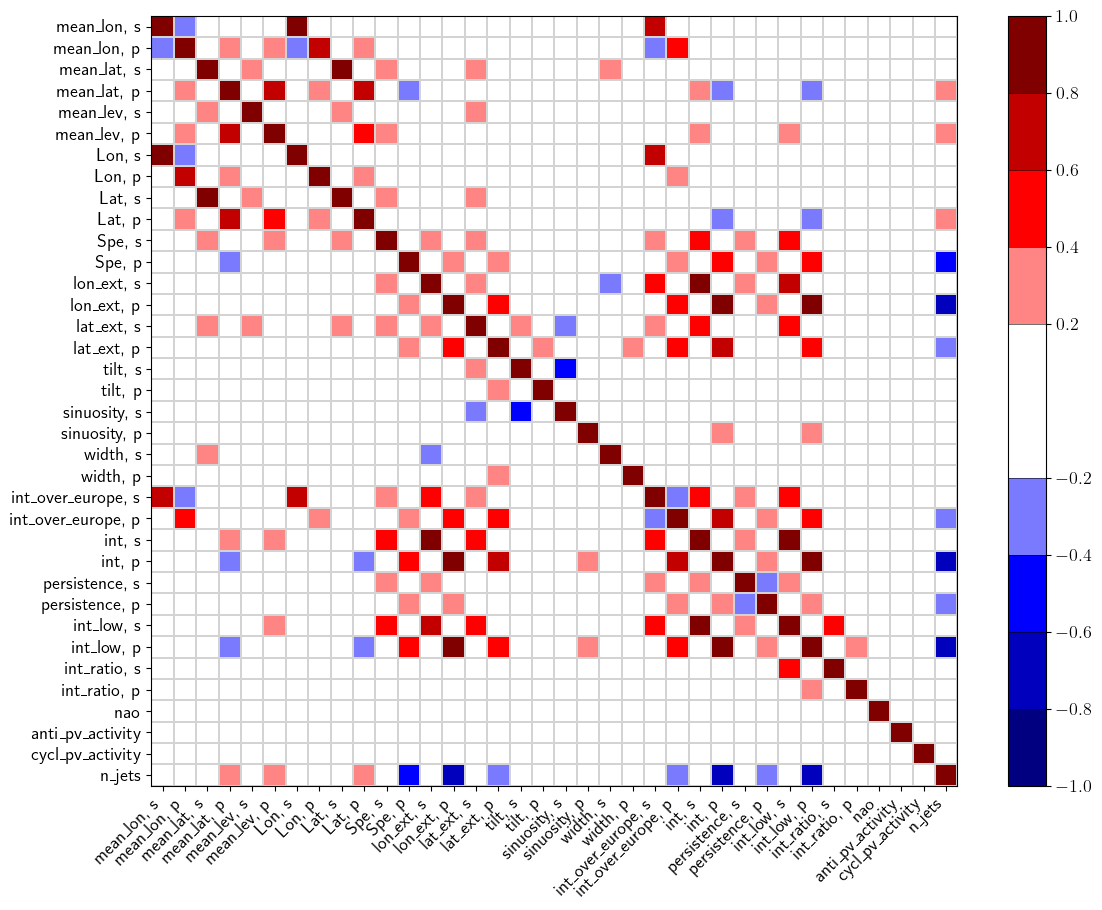

In [27]:
to_concat = []
ticks = []
valids = props_as_ds_late["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
    ]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).values[valids])
            ticks.append(f"{varname}, {jet[0]}")
    else:
        to_concat.append(np.roll(da.values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm, lw=0.01, edgecolors="lightgrey")
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full.png")

# Seasonal variability ?

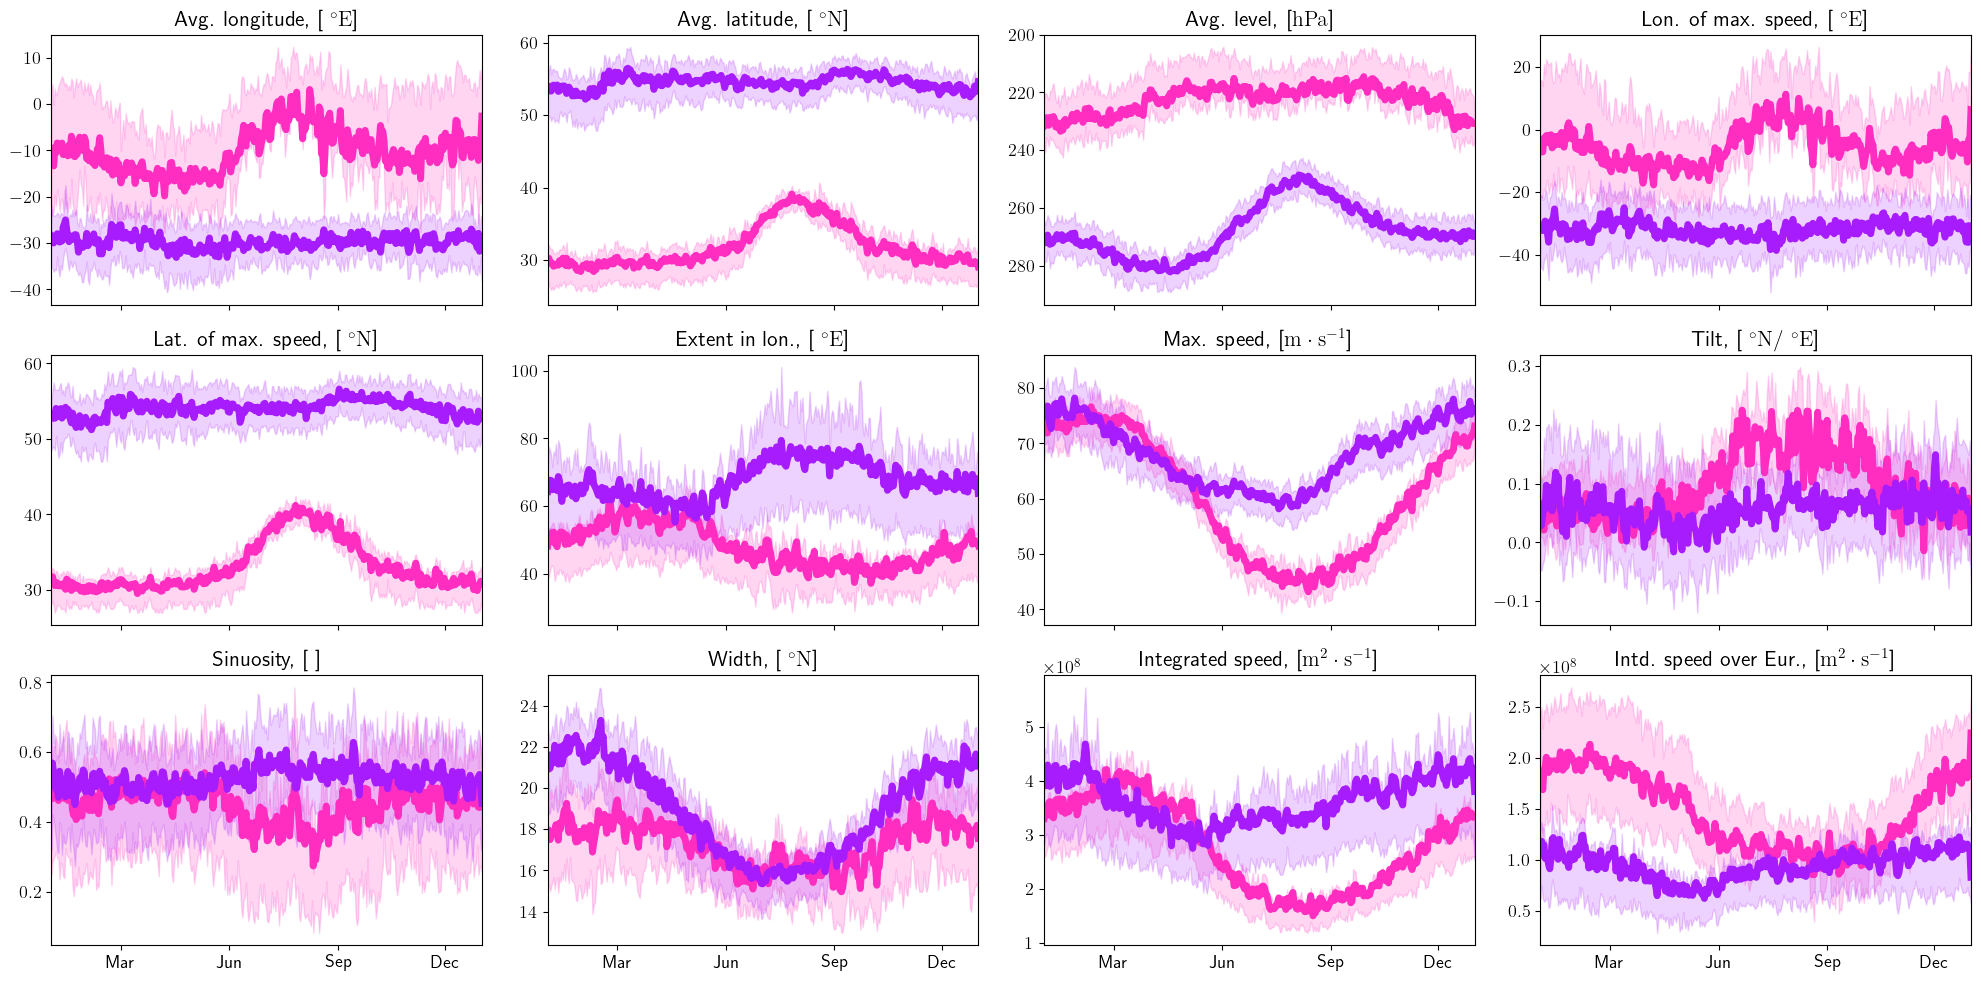

In [9]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "Spe", "tilt", "sinuosity", "width", "int", "int_over_europe"]

fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
for varname, ax in zip(data_vars, axes.ravel()):
    gb = props_as_ds[varname].groupby("time.dayofyear")
    x = list(gb.groups.keys())
    x = DATERANGEPL_EXT[x]
    ys = gb.mean().values
    qs = gb.quantile(q=[0.33, 0.66]).values
    for i in range(2):
        ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=COLORS[2 - i], alpha=0.2)
        ax.plot(x, ys[:, i], lw=5, color=COLORS[2 - i])
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal.png")

# Subset plots

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/groupby.py:532: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index_grouper = pd.Grouper(


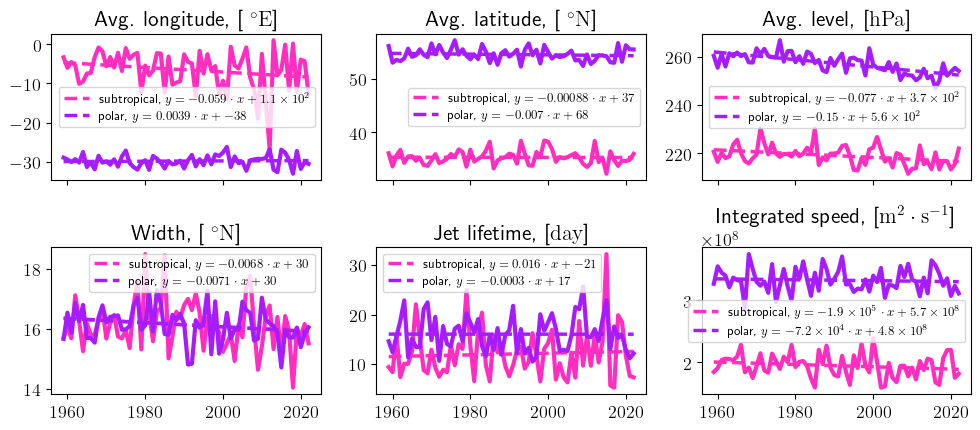

In [14]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "width", "persistence", "int"]
fig, axes = plt.subplots(2, 3, figsize=(10, 4.5), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [6, 7, 8])
props_as_ds_yearly_hs = (
    props_as_ds.sel(time=high_summer_mask).resample(time="1Y").mean()
)
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS[2 - j])
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(
                x,
                c1 * x + c0,
                lw=2.5,
                color=COLORS[2 - j],
                ls="dashed",
                label=f"{jet}, {p_to_tex(c1, c0)}",
            )
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            c1, c0 = np.polyfit(x, this_da.values, deg=1)
            ax.plot(x, c1 * x + c0, lw=2.5, color="black", ls="dashed", label=f"{p_to_tex(c1, c0)}")
            break
    ax.legend(ncol=1, fontsize=9)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959_summer_subset.png")

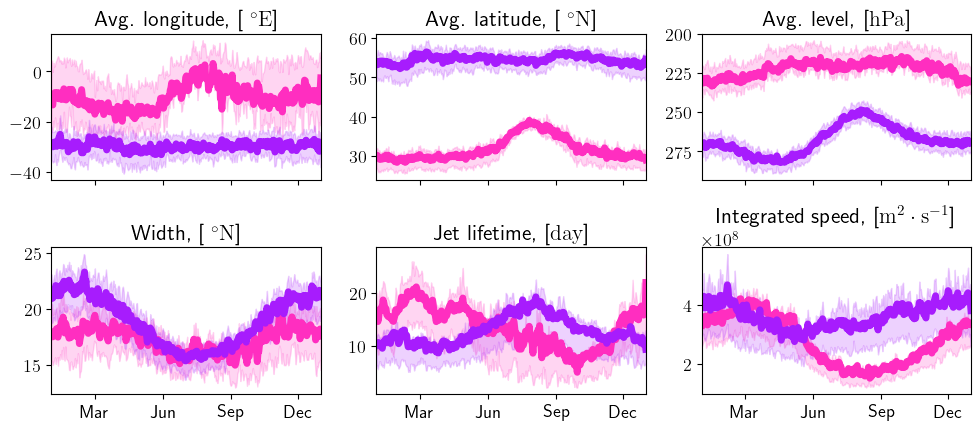

In [15]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = ["mean_lon", "mean_lat", "mean_lev", "width", "persistence", "int"]

fig, axes = plt.subplots(2, 3, figsize=(10, 4.5), tight_layout=True, sharex="all")
for varname, ax in zip(data_vars, axes.ravel()):
    gb = props_as_ds[varname].groupby("time.dayofyear")
    x = list(gb.groups.keys())
    x = DATERANGEPL_EXT[x]
    ys = gb.mean().values
    qs = gb.quantile(q=[0.33, 0.66]).values
    for i in range(2):
        ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=COLORS[2 - i], alpha=0.2)
        ax.plot(x, ys[:, i], lw=5, color=COLORS[2 - i])
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal_subset.png")

# Demo: double anim

In [ ]:
r1 = len(da_s.lon) / len(da_s.lat)
r2 = 1
height = 4
wspace = 0.04
cbar_size = 0.05
fig = plt.figure(
    figsize=(height * (r1 + r2 + 2 * cbar_size + 3 * wspace), height), dpi=90
)
gs = GridSpec(
    1,
    5,
    width_ratios=(r1, cbar_size, 4 * wspace, r2, cbar_size),
    wspace=0.02,
    figure=fig,
)

fig.add_subplot(gs[2], visible=False)
ax_contourf = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax_contourf.set_extent(
    exp_s.region,
    crs=ccrs.PlateCarree(),
)
ax_contourf.add_feature(COASTLINE)
cs = ax_contourf.contourf(
    da_s.lon.values, da_s.lat.values, da_s[tsteps[0]].values, **kwargs_contourf
)
cax = fig.add_subplot(gs[1])
fig.colorbar(cs, cax=cax)

ax_trajectory = fig.add_subplot(gs[3])
# ax_trajectory.plot([1, 2])
kwargs_trajectory = dict(
    cmap=mpl.colormaps["gray_r"], norm=Normalize(np.amin(thesepops), np.amax(thesepops))
)
xlims = [
    np.amin(coords[~outermask][:, 0]) - 0.8,
    np.amax(coords[~outermask][:, 0]) + 0.8,
]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
fig, ax_trajectory = splots.plot_map(
    coords,
    populations,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors="black",
    cmap="Greys",
    alphas=alphas,
    linewidths=0,
    fig=fig,
    ax=ax_trajectory,
)
cax = fig.add_axes([0.67, 0.84, 0.06, 0.04])
im = ScalarMappable(**kwargs_trajectory)
fig.colorbar(im, cax=cax, orientation="horizontal", ticks=[])
cax.text(-5, 0.35, "0", ha="center", va="center")
max_pop = np.amax(populations)
cax.text(max_pop + 9, 0.35, f"{max_pop}", ha="center", va="center")

lc = LineCollection(segments, cmap="magma", norm=norm)
lc.set_array(np.repeat(np.arange(len(traj) - 1), repeats=reps))
lc.set_linewidth(3)
lc = ax_trajectory.add_collection(lc)
cax = fig.add_subplot(gs[4])
cbar = fig.colorbar(lc, label=f"Days of summer {YEARSPL[yearidx]}", cax=cax)
list_of_days = np.asarray([0, 14 * 4, 30 * 4, 44 * 4, 61 * 4, 75 * 4, 91 * 4 + 3])

pretty_list_of_days = (
    da.time[yearidx * 92 * 4 + list_of_days].dt.strftime("%b %d").values
)
cbar.ax.set_yticks(list_of_days, labels=pretty_list_of_days)
cbar.ax.invert_yaxis()
ax_trajectory.set_xlim(xlims)
ax_trajectory.set_ylim(ylims)

jets = all_jets[tsteps[0]]
lines = []
for j in range(3):
    try:
        jet = jets[j]
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        newy = p(x)
    except IndexError:
        x, newy, s = [], [], []

    lines.append(ax_contourf.plot(x, newy, color="dimgray", lw=4)[0])


def animate(i):
    global cs
    global lines
    global lc
    for c in cs.collections:
        c.remove()
    cs = ax_contourf.contourf(
        da_s.lon.values, da_s.lat.values, da_s[tsteps[i]].values, **kwargs_contourf
    )
    jets = all_jets[tsteps[i]]
    for j in range(3):
        try:
            jet = jets[j]
            x, y, s = jet.T
        except IndexError:
            x, y, s = [], [], []
        lines[j].set_data(x, y)
    if i > 1:
        to_be_set_visible = np.sum(reps[:i])
        lws = np.zeros(len(segments))
        lws[:to_be_set_visible] = 4
        lc.set_lw(lws)
    else:
        lc.set_lw(0.0)
    fig.suptitle(titles[i])
    return cs, lines, lc


ani = FuncAnimation(fig, animate, frames=np.arange(len(tsteps)))
ani.save("Figures/double_anim.gif", dpi=200, fps=5)